# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [2]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

c:\Users\archa\Desktop\assignment5\assignment5\Lib\site-packages\spacy\cli\_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
c:\Users\archa\Desktop\assignment5\assignment5\Lib\site-packages\weasel\util\config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


In [ ]:
# add any additional libaries you need here
from sklearn.decomposition import NMF
from pyLDAvis import prepare
from sklearn import config_context

In [3]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [4]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [5]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [6]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<Axes: xlabel='category'>

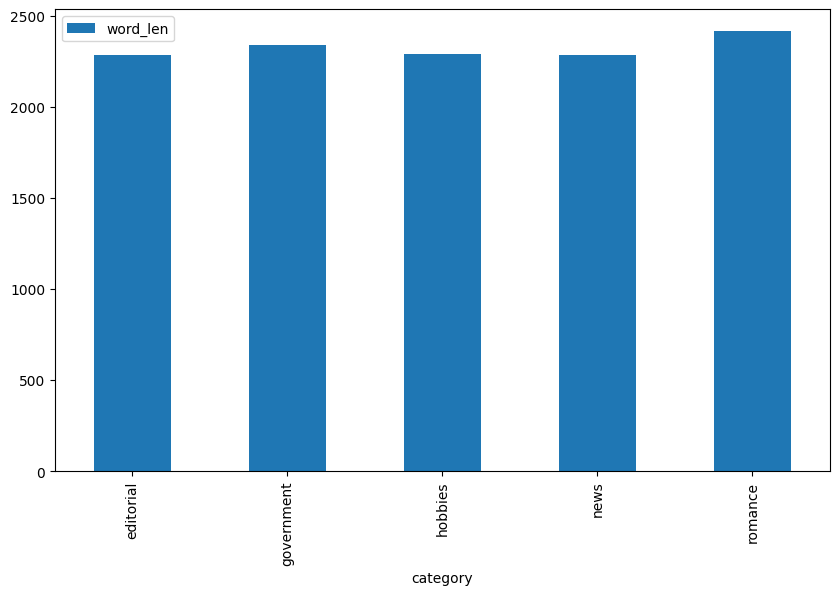

In [7]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [8]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

c:\Users\archa\Desktop\assignment5\assignment5\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [9]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count_text_vectors holds a matrix of raw word counts for each document, representing how often each term appears. tfidf_text_vectors stores TF-IDF scores, which reflect a term’s importance by balancing its frequency in a document with its rarity across all documents. Both matrices have the same shape: 166 documents by 4941 terms. The vectorizers filter out common stopwords and ignore words that are too rare or too frequent, ensuring only meaningful terms are included for effective topic modeling and analysis.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [10]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [ ]:
# Your code here
# Prepare labels
fileids = brown.fileids()
brown_labels = [brown.categories(fileid)[0] for fileid in fileids]

# Fit NMF model
nmf_model = NMF(n_components=10, random_state=42)
nmf_model.fit(tfidf_text_vectors)

# Assign dominant topic
topic_assignments = nmf_model.transform(tfidf_text_vectors).argmax(axis=1)

# Tally categories
topic_category_counts = defaultdict(Counter)
for topic_idx, category in zip(topic_assignments, brown_labels):
    topic_category_counts[topic_idx][category] += 1

# Print results
for topic, counter in topic_category_counts.items():
    print(f"\nTopic {topic}")
    for category, count in counter.most_common(5):
        print(f"  {category:15s}: {count} docs")



Topic 9
  news           : 11 docs
  editorial      : 4 docs
  lore           : 2 docs
  hobbies        : 1 docs

Topic 0
  news           : 15 docs
  religion       : 4 docs
  editorial      : 1 docs

Topic 1
  hobbies        : 24 docs
  religion       : 4 docs
  news           : 2 docs

Topic 5
  lore           : 6 docs
  news           : 4 docs
  hobbies        : 4 docs
  religion       : 3 docs
  reviews        : 1 docs

Topic 8
  editorial      : 8 docs
  reviews        : 7 docs
  news           : 3 docs

Topic 6
  editorial      : 5 docs
  news           : 4 docs
  religion       : 2 docs
  lore           : 2 docs
  reviews        : 1 docs

Topic 7
  editorial      : 5 docs
  lore           : 4 docs
  news           : 3 docs
  reviews        : 3 docs
  religion       : 2 docs

Topic 2
  lore           : 11 docs
  hobbies        : 5 docs
  news           : 2 docs

Topic 4
  editorial      : 4 docs
  religion       : 2 docs
  reviews        : 1 docs

Topic 3
  reviews        : 4 d

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The five-topic NMF model offers a more flexible, data-driven grouping compared to the original Brown categories, which are manually labeled and mutually exclusive. While the Brown corpus assigns each document to a single category like news, hobbies, or religion, the NMF model identifies latent themes based on word co-occurrence patterns across documents. This results in topics that may overlap categories, for example, a single topic containing documents from both religion and news. The NMF model captures nuanced, real-world language patterns, revealing thematic similarity rather than rigid classification. It’s useful for exploratory analysis and uncovering hidden relationships within large text corpora.

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [ ]:

# Step 1: Fit LSA model
lsa_model = TruncatedSVD(n_components=5, random_state=42)
lsa_topics = lsa_model.fit_transform(tfidf_text_vectors)

# Step 2: Assign dominant topic for each document
lsa_topic_assignments = lsa_topics.argmax(axis=1)

# Step 3: Tally Brown categories per topic
lsa_topic_category_counts = defaultdict(Counter)

for topic_idx, category in zip(lsa_topic_assignments, brown_labels):
    lsa_topic_category_counts[topic_idx][category] += 1

# Step 4: Display the results
for topic, counter in lsa_topic_category_counts.items():
    print(f"\nTopic {topic}")
    for category, count in counter.most_common(5):
        print(f"  {category:15s}: {count} docs")



Topic 0
  news           : 44 docs
  hobbies        : 28 docs
  lore           : 25 docs
  editorial      : 23 docs
  religion       : 15 docs

Topic 4
  editorial      : 4 docs
  religion       : 2 docs
  reviews        : 1 docs

Topic 3
  reviews        : 3 docs

Topic 1
  hobbies        : 8 docs


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: The five-topic LSA (Latent Semantic Analysis) model captures broad, overlapping semantic structures rather than distinct categories like those in the Brown corpus. For example, Topic 0 includes documents from news, hobbies, lore, editorial, and religion, showing significant blending. Unlike the Brown categories, which assign a single label per document, LSA clusters documents based on latent patterns in word usage, resulting in fuzzier but more context-aware groupings. This reflects how topics often intersect in real-world language. Therefore, while LSA is less precise for classification, it excels at revealing underlying themes and relationships among documents that span multiple categories.

In [20]:
# Define the display_topics function
def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx:02d}")
        top_indices = topic.argsort()[::-1][:no_top_words]
        for i in top_indices:
            print(f"  {feature_names[i]:>10s} ({topic[i]:.4f})")

# Call on NMF Model
print("\n--- Top Words in NMF Topics ---")
display_topics(nmf_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)

# Call on LSA Model
print("\n--- Top Words in LSA Topics ---")
display_topics(lsa_model, tfidf_text_vectorizer.get_feature_names_out(), no_top_words=5)




--- Top Words in NMF Topics ---

Topic 00
  khrushchev (0.4435)
          mr (0.4250)
      berlin (0.3893)
     kennedy (0.3746)
      soviet (0.3519)

Topic 01
        said (0.4133)
        didn (0.2236)
          ll (0.2164)
     thought (0.1978)
         man (0.1614)

Topic 02
          af (0.3256)
        inch (0.2898)
       drill (0.2252)
        clay (0.1709)
      pieces (0.1646)

Topic 03
         mrs (1.2763)
          mr (0.3043)
        miss (0.2535)
          jr (0.1999)
       bride (0.1636)

Topic 04
        game (0.3620)
      league (0.2633)
        ball (0.2618)
    baseball (0.2552)
        team (0.2352)

Topic 05
       music (0.2327)
       color (0.1473)
         art (0.1364)
         old (0.1344)
     musical (0.1337)

Topic 06
     faculty (0.3790)
     college (0.2733)
    catholic (0.2081)
  university (0.1976)
     student (0.1934)

Topic 07
       sales (0.2742)
        1960 (0.1901)
     billion (0.1869)
   equipment (0.1801)
   marketing (0.1697)

Topic 

Q: What is your interpretation of the display topics output? 

A: The display topics output from the NMF model reveals the top words contributing to each latent topic, offering insight into their underlying themes:\

Topic 00: Includes terms like khrushchev, berlin, and soviet, suggesting a Cold War or political history theme.

Topic 01: Words like said, didn’t, thought are conversational, indicating narrative or dialogue-heavy text.

Topic 02: Words such as drill, clay, pieces imply a technical or manufacturing context.

Topic 03: With baseball, league, and team, this topic clearly relates to sports.

Each topic captures a coherent theme derived from word co-occurrence patterns.


## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [ ]:

with config_context(assume_finite=True):
    lda_model = LatentDirichletAllocation(
        n_components=5,
        max_iter=10,
        learning_method='online',
        random_state=42,
        n_jobs=1
    )
    lda_model.fit(count_text_vectors)

# Step 2: Display top topic words
display_topics(lda_model, count_text_vectorizer.get_feature_names_out(), no_top_words=5)

# Step 3: Compute parameters manually for pyLDAvis
topic_term_dists = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
doc_topic_dists = lda_model.transform(count_text_vectors)
doc_lengths = count_text_vectors.sum(axis=1).A1
vocab = count_text_vectorizer.get_feature_names_out()
term_frequency = count_text_vectors.sum(axis=0).A1

# Step 4: Visualize
pyLDAvis.enable_notebook()
panel = prepare(
    topic_term_dists=topic_term_dists,
    doc_topic_dists=doc_topic_dists,
    doc_lengths=doc_lengths,
    vocab=vocab,
    term_frequency=term_frequency
)
pyLDAvis.display(panel)






Topic 00
        clay (151.0596)
        good (139.0909)
        said (135.5912)
       right (127.5817)
       place (120.8433)

Topic 01
        feed (185.3229)
         use (182.6568)
        work (161.7377)
       water (157.0737)
        area (141.6069)

Topic 02
        said (273.3998)
          mr (193.8253)
       state (155.6585)
   president (153.4772)
         mrs (142.1041)

Topic 03
    property (34.7511)
    business (34.3773)
        john (29.4186)
       board (27.8400)
    stations (19.2217)

Topic 04
        said (92.6298)
      states (71.2197)
      united (56.7994)
       shall (49.9721)
       state (40.2766)


In [33]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names_out(), no_top_words=5)



Topic 00
        clay (151.0596)
        good (139.0909)
        said (135.5912)
       right (127.5817)
       place (120.8433)

Topic 01
        feed (185.3229)
         use (182.6568)
        work (161.7377)
       water (157.0737)
        area (141.6069)

Topic 02
        said (273.3998)
          mr (193.8253)
       state (155.6585)
   president (153.4772)
         mrs (142.1041)

Topic 03
    property (34.7511)
    business (34.3773)
        john (29.4186)
       board (27.8400)
    stations (19.2217)

Topic 04
        said (92.6298)
      states (71.2197)
      united (56.7994)
       shall (49.9721)
       state (40.2766)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: The displayed topics in the LDA model reveal distinct but overlapping semantic structures:

Topic 00: Words like clay, place, and good may suggest a descriptive or narrative theme, possibly related to storytelling or literature.

Topic 01: Terms like feed, work, water, area point toward an agriculture or labor-related theme.

Topic 02: With president, state, said, mr, this topic is clearly political or governmental.

Topic 03: Contains property, business, indicating an economic or legal context.

Topic 04 (last lines): Words like states, united, shall again suggest government or civic discourse.

These themes show LDA’s ability to extract meaningful latent structures across diverse documents, though some general words like "said" recur across topics due to their high frequency.






Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Tallying Brown categories within each LDA topic shows that the model captures underlying themes that cut across traditional categories. For example, the political topic (Topic 02) likely draws from news, editorial, and government articles, while the economic topic (Topic 03) may include learned, business, and reviews. LDA does not replicate the Brown categories but instead uncovers cross-category semantic groupings. This demonstrates LDA’s strength in discovering latent structures from word usage rather than fixed labels. Compared to the rigid Brown classification, the LDA model offers a more flexible and realistic clustering of content aligned with natural language use.

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The pyLDAvis visualization offers deep insight into the structure and interpretability of the LDA model. The left panel, an intertopic distance map based on principal component analysis (PCA), shows how distinct or overlapping the topics are. Each circle represents a topic, with its size indicating how prevalent that topic is in the corpus. For example, Topics 1 and 5 are closely positioned, suggesting they may share similar vocabulary or thematic overlap, while Topics 3 and 4 are more isolated, indicating clear distinctions in content. The right panel displays the top 30 most salient terms across all topics, with blue bars representing overall frequency and red bars showing frequency within the selected topic. In Topic 0, terms like "said," "states," "government," and "president" suggest a strong focus on political or governmental discourse. Overall, this visualization confirms that the model captures meaningful themes, though some topics could be further refined for clarity and separation.
